<a href="https://colab.research.google.com/github/emreaskinsoftware/Twitter-Sentiment-Analysis/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import os

# Eğer dosya zaten yoksa yükle
if not os.path.exists('kaggle.json'):
  print("Lütfen 'kaggle.json' dosyanızı seçin:")
  files.upload()
else:
  print("✓ 'kaggle.json' dosyası zaten mevcut.")

In [ ]:
from google.colab import files

print("Lütfen bilgisayarınıza indirdiğiniz 'twitter-sentiment-analysis.zip' dosyasını seçin:")
uploaded = files.upload()

In [ ]:
# Yüklediğimiz ZIP dosyasını açıyoruz
!unzip -o twitter-sentiment-analysis.zip
print("✓ ZIP dosyası başarıyla açıldı.")

✓ 'twitter_training.csv' (latin-1) ile başarıyla yüklendi (Başlık düzeltildi).
Orijinal satır sayısı: 74682
Boş metinler silindi. Yeni satır sayısı: 73996

--- Veri Setinden İlk 5 Satır (head) - DÜZELTİLMİŞ ---
     id        topic sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  

--- Veri Seti Bilgileri (info) - DÜZELTİLMİŞ ---
<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         73996 n

/tmp/ipython-input-565160663.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette='viridis')


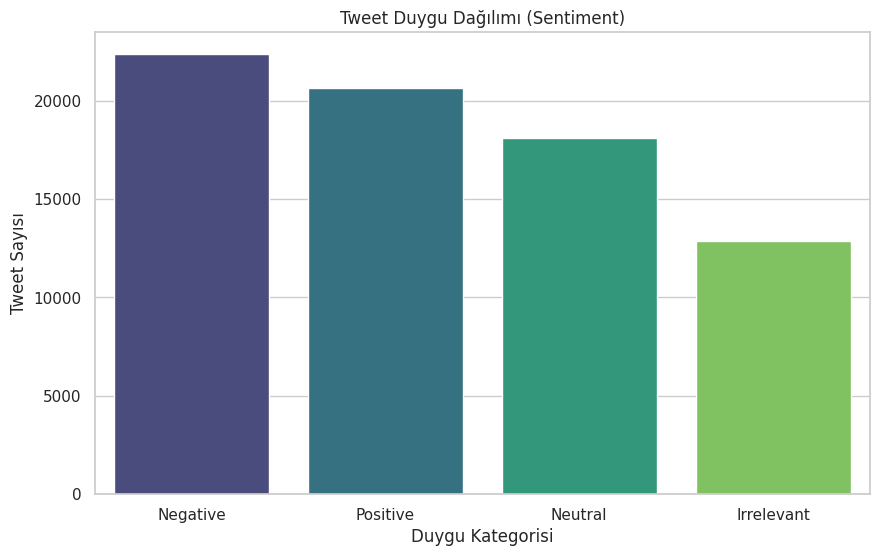

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# 'df' değişkenini 'try' bloğunun dışında 'None' olarak tanımlayalım
df = None

try:
    # --- DÜZELTME: 'header=None' ve 'names' parametrelerini ekledik ---
    column_names = ['id', 'topic', 'sentiment', 'text']
    df = pd.read_csv('twitter_training.csv',
                     encoding='latin-1',
                     header=None,  # Bu dosyada bir başlık satırı olmadığını söylüyoruz
                     names=column_names) # Kolon adlarını biz veriyoruz

    print("✓ 'twitter_training.csv' (latin-1) ile başarıyla yüklendi (Başlık düzeltildi).")

    # --- TEMİZLİK (Sizin Öneriniz) ---
    # 4. sütun olan 'text' sütunundaki boş (NaN) değerleri silelim
    print(f"Orijinal satır sayısı: {len(df)}")

    # 'dropna' komutu 'text' sütunu 'NaN' (boş) olan satırları siler
    df = df.dropna(subset=['text'])

    print(f"Boş metinler silindi. Yeni satır sayısı: {len(df)}")

except Exception as e:
    print(f"Hata oluştu: {e}")

# --- İLK ANALİZ (EDA) - Düzeltilmiş ---
if df is not None:
    print("\n--- Veri Setinden İlk 5 Satır (head) - DÜZELTİLMİŞ ---")
    print(df.head())

    print("\n--- Veri Seti Bilgileri (info) - DÜZELTİLMİŞ ---")
    df.info()

    # Artık 'sentiment' sütunumuzun olması gerekiyor
    if 'sentiment' in df.columns:
        print("\n--- Duygu (Sentiment) Dağılımı ---")
        print(df['sentiment'].value_counts())

        # Bu dağılımı görselleştirelim
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette='viridis')
        plt.title('Tweet Duygu Dağılımı (Sentiment)')
        plt.xlabel('Duygu Kategorisi')
        plt.ylabel('Tweet Sayısı')
        plt.show()
    else:
        print("Hata: 'sentiment' adında bir sütun bulunamadı.")
else:
    print("Hata: DataFrame ('df') yüklenemedi.")

In [16]:
import re # Regular Expressions kütüphanesini 'import' ediyoruz
import string

# --- Adım 3.1: Veri Filtreleme (Sizin Analizinize Göre) ---
# Sadece 'Positive' ve 'Negative' etiketli satırları tut
df_filtered = df[(df['sentiment'] == 'Positive') | (df['sentiment'] == 'Negative')].copy()

print(f"Orijinal temiz veri sayısı: {len(df)}")
print(f"'Neutral' ve 'Irrelevant' satırları filtrelendi. Kalan veri: {len(df_filtered)}")

# --- Adım 3.2: Metin Temizleme Fonksiyonunu Tanımlama ---
# Bu, NLP projelerindeki en 'profesyonel' adımlardan biridir.
def clean_text(text):
    """
    Bu fonksiyon bir metin alır ve onu ML için temizler:
    1. Tüm harfleri küçük harfe çevirir (lowercase)
    2. Linkleri (http...) kaldırır
    3. @mention'ları kaldırır
    4. #hashtag sembollerini kaldırır (kelimeyi tutar)
    5. Sayıları ve noktalama işaretlerini kaldırır
    6. Fazladan boşlukları temizler
    """
    text = text.lower() # 1. Küçük harf
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # 2. Linkler
    text = re.sub(r'\@\w+', '', text) # 3. @mention
    text = re.sub(r'#', '', text) # 4. Hashtag sembolü
    text = text.translate(str.maketrans('', '', string.punctuation)) # 5. Noktalama
    text = re.sub(r'\d+', '', text) # 5. Sayılar
    text = re.sub(r'\s+', ' ', text).strip() # 6. Fazla boşluklar

    return text

# --- Adım 3.3: Temizleme Fonksiyonunu 'text' Sütununa Uygulama ---
# .apply() fonksiyonu, 'clean_text' fonksiyonumuzu her bir satır için çalıştırır
# ve sonucunu 'cleaned_text' adında YENİ bir sütuna yazar.

print("\nMetin temizleme işlemi başlıyor (Bu işlem birkaç saniye sürebilir)...")

# 'cleaned_text' adında yeni bir sütun oluşturuyoruz
df_filtered['cleaned_text'] = df_filtered['text'].apply(clean_text)

print("✓ Metin temizleme tamamlandı.")

# --- SON KONTROL ---
print("\n--- Orijinal Metin vs Temizlenmiş Metin (head) ---")
# 'text' (orijinal) ve 'cleaned_text' (yeni) sütunlarını yan yana görelim
print(df_filtered[['text', 'cleaned_text', 'sentiment']].head())

print("\n--- Yeni Veri Seti Bilgileri ---")
df_filtered.info()

print("\n--- Yeni Duygu Dağılımı ---")
print(df_filtered['sentiment'].value_counts())

Orijinal temiz veri sayısı: 73996
'Neutral' ve 'Irrelevant' satırları filtrelendi. Kalan veri: 43013

Metin temizleme işlemi başlıyor (Bu işlem birkaç saniye sürebilir)...
✓ Metin temizleme tamamlandı.

--- Orijinal Metin vs Temizlenmiş Metin (head) ---
                                                text  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                                        cleaned_text sentiment  
0  im getting on borderlands and i will murder yo...  Positive  
1  i am coming to the borders and i will kill you...  Positive  
2  im getting on borderlands and i will kill you all  Positive  
3  im coming on borderlands and i will murder you...  Positive  
4  im getting on borderlands and i will murder yo...  Positive  

--- Yeni Veri Seti

In [18]:
# --- Adım 4.1: Eğitim Setini Ayırma ---
# (df_filtered ve clean_text fonksiyonunun bir önceki aşamadan
#  hafızada olduğunu varsayıyoruz)

# X_train = Filtrelenmiş EĞİTİM dosyasının TAMAMI
X_train = df_filtered['cleaned_text']
y_train = df_filtered['sentiment']

print(f"✓ Eğitim Seti (X_train) {len(X_train)} satır olarak hazırlandı.")
print(f"✓ Eğitim Seti (y_train) {len(y_train)} etiket olarak hazırlandı.")

✓ Eğitim Seti (X_train) 43013 satır olarak hazırlandı.
✓ Eğitim Seti (y_train) 43013 etiket olarak hazırlandı.


In [19]:
# --- Adım 4.2: Validasyon (Test) Verisini Yükleme ve Temizleme ---

print("Validasyon seti yükleniyor...")
column_names = ['id', 'topic', 'sentiment', 'text']
try:
    df_val = pd.read_csv('twitter_validation.csv',
                         encoding='latin-1',
                         header=None,
                         names=column_names)
    print(f"✓ Validasyon seti (df_val) {len(df_val)} satır olarak yüklendi.")

    # --- TEMİZLİK (Validasyon Seti için) ---

    # 1. Boş metinleri at (eğer varsa)
    df_val = df_val.dropna(subset=['text'])

    # 2. 'Irrelevant' ve 'Neutral' olanları at (EĞİTİMDE NE YAPTIYSAK AYNISI)
    df_val_filtered = df_val[(df_val['sentiment'] == 'Positive') | (df_val['sentiment'] == 'Negative')].copy()

    # 3. Aynı 'clean_text' fonksiyonunu uygula
    # (Bu fonksiyonun bir önceki aşamada (Aşama 3.2) tanımlanmış olması gerekir)
    df_val_filtered['cleaned_text'] = df_val_filtered['text'].apply(clean_text)

    print(f"✓ Validasyon seti temizlendi. Test için kalan satır: {len(df_val_filtered)}")

except FileNotFoundError:
    print("Hata: 'twitter_validation.csv' dosyası bulunamadı. Lütfen !ls ile kontrol edin.")
except NameError as e:
    print(f"Hata: 'clean_text' fonksiyonu bulunamadı. Lütfen Aşama 3.2'yi tekrar çalıştırın. {e}")

Validasyon seti yükleniyor...
✓ Validasyon seti (df_val) 1000 satır olarak yüklendi.
✓ Validasyon seti temizlendi. Test için kalan satır: 543


In [20]:
# --- Adım 4.3 (Güncellendi): Test Setini Ayırma ---

X_test = df_val_filtered['cleaned_text']
y_test = df_val_filtered['sentiment']

print(f"✓ Test Seti (X_test) {len(X_test)} satır olarak hazırlandı.")
print(f"✓ Test Seti (y_test) {len(y_test)} etiket olarak hazırlandı.")

✓ Test Seti (X_test) 543 satır olarak hazırlandı.
✓ Test Seti (y_test) 543 etiket olarak hazırlandı.


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Vektörleştiriciyi (TF-IDF) oluştur
vectorizer = TfidfVectorizer(max_features=5000)

print("Vektörleştirici X_train (Eğitim) verisi üzerinde eğitiliyor...")
# 2. ÖLÇEĞİ EĞİTİM VERİSİNDEN (X_train) ÖĞREN ve DÖNÜŞTÜR
X_train_v = vectorizer.fit_transform(X_train)

print("Eğitim verisinden öğrenilen sözlük Test verisine uygulanıyor...")
# 3. TEST VERİSİNİ (X_test) EĞİTİMDEN ÖĞRENDİĞİN SÖZLÜKLE DÖNÜŞTÜR
X_test_v = vectorizer.transform(X_test)

print("\n✓ Metin verisi başarıyla TF-IDF vektörlerine dönüştürüldü.")
print(f"X_train_v (sayısal) matrisinin boyutu: {X_train_v.shape}")
print(f"X_test_v (sayısal) matrisinin boyutu: {X_test_v.shape}")

Vektörleştirici X_train (Eğitim) verisi üzerinde eğitiliyor...
Eğitim verisinden öğrenilen sözlük Test verisine uygulanıyor...

✓ Metin verisi başarıyla TF-IDF vektörlerine dönüştürüldü.
X_train_v (sayısal) matrisinin boyutu: (43013, 5000)
X_test_v (sayısal) matrisinin boyutu: (543, 5000)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Modeli oluştur
# max_iter=1000 -> Modelin en iyi çözümü bulmak için
# deneme sayısını artırır (özellikle 5000 özellik varken)
model_lr = LogisticRegression(max_iter=1000, random_state=42)

print("Model (Logistic Regression) eğitiliyor...")
print("(Bu işlem, 43.000 satır ve 5.000 özellik üzerinde birkaç saniye sürebilir...)")

# 2. Modeli EĞİT (Fit)
# X_train_v (sayısal metin) ve y_train (etiketler) arasındaki
# matematiksel ilişkiyi öğrenir.
model_lr.fit(X_train_v, y_train)

print("\n✓ Model başarıyla eğitildi!")

Model (Logistic Regression) eğitiliyor...
(Bu işlem, 43.000 satır ve 5.000 özellik üzerinde birkaç saniye sürebilir...)

✓ Model başarıyla eğitildi!


In [23]:
print("Model, daha önce hiç görmediği test verileri üzerinde tahmin yapıyor...")

# 3. TAHMİN Yap (Predict)
# Modelden X_test_v'deki tweet'ler için tahmin yapmasını istiyoruz
y_pred_lr = model_lr.predict(X_test_v)

print("✓ Tahminler tamamlandı.")

# 4. DEĞERLENDİR (Evaluate)
# Modelin tahminlerini (y_pred_lr) gerçek cevaplarla (y_test) karşılaştır

# a) Doğruluk (Accuracy) Skoru
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"\n--- Model Doğruluk (Accuracy) Skoru ---")
print(f"{accuracy * 100:.2f}%")
print(f"(Model, {len(y_test)} test tweet'inin {int(accuracy * len(y_test))} tanesini doğru tahmin etti.)")

# b) Detaylı Sınıflandırma Raporu (Precision, Recall)
# Modelimizin nerede (Pozitif mi, Negatif mi) daha başarılı olduğunu gösterir
print("\n--- Detaylı Sınıflandırma Raporu ---")
print(classification_report(y_test, y_pred_lr))

Model, daha önce hiç görmediği test verileri üzerinde tahmin yapıyor...
✓ Tahminler tamamlandı.

--- Model Doğruluk (Accuracy) Skoru ---
92.08%
(Model, 543 test tweet'inin 500 tanesini doğru tahmin etti.)

--- Detaylı Sınıflandırma Raporu ---
              precision    recall  f1-score   support

    Negative       0.91      0.93      0.92       266
    Positive       0.93      0.91      0.92       277

    accuracy                           0.92       543
   macro avg       0.92      0.92      0.92       543
weighted avg       0.92      0.92      0.92       543

